In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option('display.max_colwidth', None)

import string

# import spacy
import swifter
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams

from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Noble\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Noble\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Noble\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Noble\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

## Data Exploration

In [3]:
df = pd.read_csv('./data/sample30.csv')

In [4]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

```user_sentiment``` column has one missing value.Lets check the review_text for further analysis

In [7]:
df[df['user_sentiment'].isnull()]['reviews_text'][28354]

'my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy'

In [8]:
### Review content seems more Positive oriented so replace NaN with 'Positive' sentiment
df.loc[df['user_sentiment'].isnull(), 'user_sentiment'] = 'Positive'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        30000 non-null  object
dtypes: int64(1), object(14)
memory usage

## Recommendation System

For recommendation system, we need to only worry about ratings, users and products(name)

In [10]:
## For recommendation system, we need to only worry about 
## ratings, users and products(name)
recommendation_df = df[['reviews_username', 'name', 'reviews_rating']]

In [11]:
recommendation_df.rename(columns={'reviews_username': 'users', 'name': 'products', 'reviews_rating': 'ratings'}, inplace=True)

C:\Users\Noble\anaconda3\envs\dl-nlp-env\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [12]:
recommendation_df['ratings'].describe()

count    30000.000000
mean         4.483133
std          0.988441
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [13]:
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   users     29937 non-null  object
 1   products  30000 non-null  object
 2   ratings   30000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 937.5+ KB


In [14]:
recommendation_df.head()

,users,products,ratings
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
3,rebecca,K-Y Love Sensuality Pleasure Gel,1
4,walker557,K-Y Love Sensuality Pleasure Gel,1


In [15]:
recommendation_df[recommendation_df['users'].isnull()]['products'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                                                  20
Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com              13
Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz                         11
Clambake (dvd)                                                                                              3
Stander Pt Bedcane - Bed Handle                                                                             2
Yes To Carrots Nourishing Body Wash                                                                         2
Heiress (dvd)                                                                                               2
Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural                         1
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo                                                    1
Vaseline I

In [16]:
recommendation_df = recommendation_df[~recommendation_df['users'].isnull()]

In [17]:
# recommendation_df.drop_duplicates(subset=None, inplace=True)

In [18]:
recommendation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   users     29937 non-null  object
 1   products  29937 non-null  object
 2   ratings   29937 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 935.5+ KB


In [19]:
train, test = train_test_split(recommendation_df, train_size=0.75, random_state=42)

In [20]:
train.shape, test.shape

((22452, 3), (7485, 3))

In [21]:
## Keeping a dummy copy of train set for prediction
dummy_train = train.copy()

## Set the ratings of products as 1 for which user has not rated
dummy_train['ratings'] = dummy_train['ratings'].apply(lambda x: 0 if x>=1 else 1)

## create pivot table with ratings of products yet to be rated as 1 else 0
dummy_train = dummy_train.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).fillna(1)

print(dummy_train.shape)

dummy_train.head(15)

(19431, 260)


products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
08dallas,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
09mommy11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.11E+24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### User-User based Collaborative Filtering

* First, we create user-item ratings pivot matrix
* Create a user-user correlation matrix
* Predict ratings for all products (rated or otherwise) by each user
* Finally we predict ratings of all those items for user that have not been rated, which is then passed on as recommendations

In [22]:
## Create user-item pivot
df_pivot = train.pivot_table(
    index='users',
    columns='products',
    values='ratings'
)

df_pivot.head(15)

products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08dallas,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09mommy11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.11E+24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_pivot.shape

(19431, 260)

####  User similarity matrix

We will be using Cosine Similarity to compute correlation matrix

In [24]:
from sklearn.metrics.pairwise import pairwise_distances

In [25]:
## Let normalize the ratings with mean around 0
## along each user
# mean = np.nanmean(df_pivot, axis=1)
# # mean

# df_subtracted = (df_pivot.T-mean).T
# df_subtracted.head(15)

## Lets compute user correlation using Cosine Similarity based on the products purchased and ratings given to them
# user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')

## Substitute any NaN values to 0
user_correlation[np.isnan(user_correlation)] = 0

user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [26]:
user_correlation.shape

(19431, 19431)

In [27]:
## Setting negative correlations to 0 as we are only interested in users with some +ve correlation with other users
user_correlation[user_correlation<0] = 0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

#### Prediction

Lets predict user ratings for non-rated products. 
* First, the predicted rating for the users (for rated as well as non-rated products) is the weighted sum of correlation with the product rating. Hence, we need to perform matrix multiplication for the two matrices ‘user_correlation’ and ‘df_pivot’ - which results in ratings for all products for every user
* Next we compute ratings of only those products that were not rated by each user - which are then recommended

In [28]:
## Get ratings for all the products (rated and non-rated)
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[ 0.        ,  2.8401134 ,  0.        , ..., 13.57603372,
         2.83621895,  1.49419593],
       [ 0.        , 24.41126271,  0.        , ..., 15.60499288,
         0.        ,  0.        ],
       [ 0.        , 24.41126271,  0.        , ..., 15.60499288,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  8.35058613,  0.        , ..., 11.37103222,
         3.07728727,  0.        ],
       [ 0.        ,  0.8256251 ,  0.        , ..., 11.70276753,
         2.98963727,  1.34164079],
       [ 0.        ,  8.35058613,  0.        , ..., 11.37103222,
         3.07728727,  0.        ]])

In [29]:
## Get ratings of all non rated products which can be passed on as recommendations
user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
user_final_ratings

products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,2.840113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.544828,...,1.988981,0.0,0.0,0.0,1.971150,0.0,0.0,13.576034,2.836219,1.494196
01impala,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
02dakota,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
02deuce,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
0325home,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000
zxjki,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000
zyiah4,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000


In [30]:
user_final_ratings.head(15)

products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,2.840113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.544828,...,1.988981,0.0,0.0,0.0,1.971150,0.0,0.0,13.576034,2.836219,1.494196
01impala,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
02dakota,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
02deuce,0.0,24.411263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.569777,...,2.096570,0.0,0.0,0.0,1.530992,0.0,0.0,15.604993,0.000000,0.000000
0325home,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000
06stidriver,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000
08dallas,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.664863,0.000000,0.000000
09mommy11,0.0,3.679464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,7.338293,2.886751,0.700140
1.11E+24,0.0,8.350586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.405217,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,11.371032,3.077287,0.000000


#### Evaluation

In [31]:
common = test[test['users'].isin(train['users'])]
common.head()

,users,products,ratings
12875,jessica,Clorox Disinfecting Wipes Value Pack Scented 1...,5
22577,at527,Clear Scalp & Hair Therapy Total Care Nourishi...,4
21657,romance318,Nexxus Exxtra Gel Style Creation Sculptor,1
23320,countprice,Godzilla 3d Includes Digital Copy Ultraviolet ...,3
21505,farbar,Nexxus Exxtra Gel Style Creation Sculptor,1


In [32]:
common.shape

(1799, 3)

In [33]:
common_user_based_matrix = common.pivot_table(
    index='users',
    columns='products',
    values='ratings'
)

In [34]:
common_user_based_matrix.shape

(1531, 129)

In [35]:
common_user_based_matrix.head()

products,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
users,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85lisa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
## Lets convert user_correlation to a datframe with user list as index and columns
# user_correlation_df = pd.DataFrame(user_correlation, index=df_subtracted.index, columns=df_subtracted.index.to_list())
user_correlation_df = pd.DataFrame(user_correlation, index=df_pivot.index, columns=df_pivot.index.to_list())


user_correlation_df

,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
users,,,,,,,,,,,,,,,,,,,,,
00sab00,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
01impala,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02dakota,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
0325home,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
zxjki,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
zyiah4,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [37]:
## Lets reduce the correlation df to only users in test set
common_users_list = common['users'].to_list()
# len(common_users_list)

user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(common_users_list)]
user_correlation_df_1 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(common_users_list)]

user_correlation_df_1[user_correlation_df_1<0] = 0
user_correlation_df_1.shape

(1531, 1531)

In [38]:
user_correlation_df_1.head()

users,1234,1234567,123charlie,1witch,85lisa,a hutch,aac06002,aalyah,aaron,abcgator,...,xavier,yamel97,yayawomack,yorkielvr,yummy,yvonne,zach,zebras,zippy,zxcsdfd
1234,1.000000,0.0,0.662266,0.0,0.0,0.0,0.0,0.0,0.611775,0.0,...,0.330972,0.0,0.0,0.0,0.0,0.529813,0.0,0.0,0.374634,0.0
1234567,0.000000,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.000000,1.0
123charlie,0.662266,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1witch,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
85lisa,0.000000,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.000000,1.0


In [39]:
## Get the predictions for all products(rated as well as non rated) in test set
common_user_predicted_ratings = np.dot(user_correlation_df_1, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[5.80295304, 3.78496941, 0.        , ..., 1.22144127, 0.        ,
        7.79183531],
       [0.        , 0.        , 3.07728727, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.88675135, 0.        , ..., 0.        , 0.        ,
        1.31227896],
       ...,
       [0.        , 0.        , 3.07728727, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.86700847],
       [0.        , 0.        , 3.07728727, ..., 0.        , 0.        ,
        0.        ]])

In [40]:
## Let get the ratings from the common set for products that are rated
dummy_test = common.copy()

## Set products to 1 if already rated else 0
dummy_test['ratings'] = dummy_test['ratings'].apply(lambda x: 1 if x>=1 else 0)

## create pivot
dummy_test = dummy_test.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).fillna(0)

dummy_test.head()

products,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
users,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
dummy_test.shape

(1531, 129)

In [42]:
## Compute ratings of only rated products
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test)
common_user_predicted_ratings

products,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Tresemme Kertatin Smooth Infusing Conditioning,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
users,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85lisa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zebras,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets compute RMSE to evaluate how close the predictions
* First we scale the predicted ratings using MinMaxScaler
* Compute the total number of products that were rated - non NaN values in pivot table
* Basically compute summation of (actual - Predictions)^2 divided by the total number of products that were rated
* Finally take the root

In [43]:
## First we scale the predicted ratings using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

X = common_user_predicted_ratings.copy()
X = X[X>0]

sc = MinMaxScaler(feature_range=(1,5))
y = sc.fit_transform(X)

# y[0:5]

In [44]:
## Compute the total number of products that were rated - non NaN values in pivot table
total_nan_count = np.count_nonzero(~np.isnan(y))
total_nan_count

1744

In [45]:
common_ = common.pivot_table(
    index='users',
    columns='products',
    values='ratings'
)

## Compute rmse
rmse = (np.sum(np.sum((common_ - y)**2))/total_nan_count)**0.5
rmse

2.084841852467448

In [46]:
user = 'joshua'

recommendations_op = user_final_ratings.loc[user].sort_values(ascending=False)[0:20]
recommendations_op

products
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        41.031789
Mike Dave Need Wedding Dates (dvd + Digital)                           21.542676
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                   14.116220
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    13.020465
The Resident Evil Collection 5 Discs (blu-Ray)                         11.417684
Tostitos Bite Size Tortilla Chips                                       7.311154
Hormel Chili, No Beans                                                  5.860649
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total               5.411070
Clorox Disinfecting Bathroom Cleaner                                    5.327245
Alex Cross (dvdvideo)                                                   5.103395
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)            4.718743
Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz      3.976583
Windex Original Gla

In [47]:
recommendation_df[recommendation_df['users']=='joshua']

,users,products,ratings
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5
1559,joshua,Dark Shadows (includes Digital Copy) (ultravio...,3
5616,joshua,Red (special Edition) (dvdvideo),4
17859,joshua,Smead174 Recycled Letter Size Manila File Back...,5
22742,joshua,Cheetos Crunchy Flamin' Hot Cheese Flavored Sn...,5


### Item-Item based Collaborative Filtering

Lets check the Item-Item based filtering to check if the recommendations are better

* First we create a User-Item based Ratings matrix using pivot table
* Then, we create Item-Item similarity (correlation) matrix
* Predict ratings for all products (rated or otherwise)
* Finally we predict ratings of all those items for user that have not been rated

In [48]:
## Create Item-User pivot
df_pivot = train.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).T

df_pivot.head()

users,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_pivot.shape

(260, 19431)

In [50]:
## Before we compute item_correlation matrix, lets average out the ratings around mean 0
## Note: Mean is computed across items instead of users

# mean = np.nanmean(df_pivot, axis=1)
# # len(mean)

# df_subtracted = (df_pivot.T-mean).T
# print(df_subtracted.head())

## Lets compute Item-correlation matrix using Cosine Similarity
# item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')

## Substitute NaN values to 0
item_correlation[np.isnan(item_correlation)] = 0

item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.00229002, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00229002, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [51]:
## Ignoring negative correlations as we are only looking for users with +ve correlation

item_correlation[item_correlation<0] = 0
item_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.00229002, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00229002, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [52]:
item_correlation.shape

(260, 260)

In [53]:
## Lets compute predicted ratings for all products(rated/non-rated)

item_predicted_ratings = np.dot((df_pivot.fillna(0).T), item_correlation)
item_predicted_ratings

array([[0.        , 0.02312729, 0.        , ..., 0.05629205, 0.0167301 ,
        0.0222563 ],
       [0.        , 0.0638275 , 0.        , ..., 0.03021493, 0.        ,
        0.        ],
       [0.        , 0.10637917, 0.        , ..., 0.05035821, 0.        ,
        0.        ],
       ...,
       [0.        , 0.0243351 , 0.        , ..., 0.02103937, 0.01044702,
        0.        ],
       [0.        , 0.01485814, 0.        , ..., 0.07054811, 0.0278835 ,
        0.0334357 ],
       [0.        , 0.01946808, 0.        , ..., 0.0168315 , 0.00835762,
        0.        ]])

In [54]:
item_predicted_ratings.shape

(19431, 260)

In [55]:
## Lets compute predicted ratings for only non rated products

item_final_ratings = np.multiply(item_predicted_ratings, dummy_train)
item_final_ratings

products,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
users,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.023127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066628,...,0.090846,0.0,0.0,0.0,0.065347,0.0,0.0,0.056292,0.016730,0.022256
01impala,0.0,0.063828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038870,...,0.042801,0.0,0.0,0.0,0.022759,0.0,0.0,0.030215,0.000000,0.000000
02dakota,0.0,0.106379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064783,...,0.071336,0.0,0.0,0.0,0.037932,0.0,0.0,0.050358,0.000000,0.000000
02deuce,0.0,0.085103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051827,...,0.057068,0.0,0.0,0.0,0.030345,0.0,0.0,0.040287,0.000000,0.000000
0325home,0.0,0.024335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019602,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.021039,0.010447,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxcsdfd,0.0,0.024335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019602,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.021039,0.010447,0.000000
zxjki,0.0,0.009734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007841,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.008416,0.004179,0.000000
zyiah4,0.0,0.024335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019602,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.021039,0.010447,0.000000


#### Evaluation

In [56]:
## Let generate common set between test and train as we can only evaluate for products common to both set
common = test[test['products'].isin(train['products'])]
common.shape

(7473, 3)

In [57]:
common_item_based_matrix = common.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).T

common_item_based_matrix.head()

users,00dog3,1143mom,1234,1234567,123charlie,13ld,1515,1616,1753,18612,...,zimmeyb,zippy,zittles,zokhid,zombiegirl22,zoomin76,zout22389,zt313,zulaa118,zxcsdfd
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alex Cross (dvdvideo),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"All,bran Complete Wheat Flakes, 18 Oz.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
common_item_based_matrix.shape

(187, 7003)

Lets reduce the item corellation matrix to include only common products

In [59]:
## Lets create the item corellation dataframe
# item_correlation_df = pd.DataFrame(item_correlation, index=df_subtracted.index, columns=df_subtracted.index.to_list())
item_correlation_df = pd.DataFrame(item_correlation, index=df_pivot.index, columns=df_pivot.index.to_list())

# item_correlation_df = pd.DataFrame(item_correlation)
# item_correlation_df['products'] = df_subtracted.index
# item_correlation_df['products'] = df_pivot.index
# item_correlation_df.set_index('products', inplace=True)
# item_correlation_df.columns = df_subtracted.index.to_list()
# item_correlation_df.columns = df_pivot.index.to_list()

item_correlation_df

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
100:Complete First Season (blu-Ray),0.0,1.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00229,0.000000,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.00000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.00000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.00000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.156022,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wedding Wishes Wedding Guest Book,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00000,0.000000,0.0
Weleda Everon Lip Balm,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,0.000000,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.00229,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.000000,0.0


In [60]:
## Get common list of products
common_product_list = common['products'].to_list()

## Reducing correlation matrix to only common products
item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(common_product_list)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(common_product_list)]
item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3[item_correlation_df_3<0] = 0

item_correlation_df_3

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00229,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Alex Cross (dvdvideo),0.0,0.00000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.00000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.00000,0.0,0.0
Weleda Everon Lip Balm,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.00000,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.00229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006458,...,0.0,0.008088,0.000000,0.0,0.0,0.0,0.0,1.00000,0.0,0.0


In [61]:
## Generate ratings for all common products (rated/non rated)
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00687007, 0.01946808, ..., 0.10637917, 0.02516123,
        0.0243351 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07934686, 3.        , 0.0168315 , ..., 0.05035821, 0.03361923,
        0.02103937],
       [0.        , 0.        , 0.00835762, ..., 0.        , 0.        ,
        0.01044702],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [62]:
## Lets generate ratings for only those products that are rated
dummy_test = common.copy()

## Set ratings as 1 if ratings is present else 0
dummy_test['ratings'] = dummy_test['ratings'].apply(lambda x: 1 if x>=1 else 0)

## Create pivot
dummy_test = dummy_test.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).T.fillna(0)

dummy_test.head()

users,00dog3,1143mom,1234,1234567,123charlie,13ld,1515,1616,1753,18612,...,zimmeyb,zippy,zittles,zokhid,zombiegirl22,zoomin76,zout22389,zt313,zulaa118,zxcsdfd
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
dummy_test.shape

(187, 7003)

In [64]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)
common_item_predicted_ratings

users,00dog3,1143mom,1234,1234567,123charlie,13ld,1515,1616,1753,18612,...,zimmeyb,zippy,zittles,zokhid,zombiegirl22,zoomin76,zout22389,zt313,zulaa118,zxcsdfd
products,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alex Cross (dvdvideo),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets compute RMSE to evaluate how close the predictions
* First we scale the predicted ratings using MinMaxScaler
* Compute the total number of products that were rated - non NaN values in pivot table
* Basically compute summation of (actual - Predictions)^2 divided by the total number of products that were rated
* Finally take the root

In [65]:
## First we scale the predicted ratings using MinMaxScaler
X = common_item_predicted_ratings.copy()
X = X[X>0]

sc1 = MinMaxScaler(feature_range=(1,5))
y = sc1.fit_transform(X)

# y[0:5]

In [66]:
## Compute the total number of products that were rated - non NaN values in pivot table
total_nan_count = np.count_nonzero(~np.isnan(y))
total_nan_count

7304

In [67]:
common_ = common.pivot_table(
    index='users',
    columns='products',
    values='ratings'
).T

## Compute rmse
rmse = (np.sum(np.sum((common_ - y)**2))/total_nan_count)**0.5
rmse

3.5821553015427603

In [68]:
user = 'joshua'

recommendations_op = item_final_ratings.loc[user].sort_values(ascending=False)[0:20]
recommendations_op

products
Home Health Hairever Shampoo                                           0.398104
The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus               0.391763
Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz     0.219158
Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz       0.200055
Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black                      0.186300
Mike Dave Need Wedding Dates (dvd + Digital)                           0.177652
Tostitos Bite Size Tortilla Chips                                      0.174166
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                   0.173148
Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans                        0.160675
Olivella Bar Soap - 3.52 Oz                                            0.159782
Hormel Chili, No Beans                                                 0.140492
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd        0.137464
Bisquick Original Pancake And B

## Sentiment based Text Classification

In [69]:
classifier_df = df[['reviews_text', 'user_sentiment']]

## Resetting datatype of review_text and user_sentiment columns to string
classifier_df['reviews_text'] = classifier_df['reviews_text'].astype('str')
classifier_df['user_sentiment'] = classifier_df['user_sentiment'].astype('str')

C:\Users\Noble\AppData\Local\Temp/ipykernel_34504/2852453986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_df['reviews_text'] = classifier_df['reviews_text'].astype('str')
C:\Users\Noble\AppData\Local\Temp/ipykernel_34504/2852453986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_df['user_sentiment'] = classifier_df['user_sentiment'].astype('str')


In [70]:
## Check class distribution
classifier_df['user_sentiment'].value_counts(normalize=True)

Positive    0.887767
Negative    0.112233
Name: user_sentiment, dtype: float64

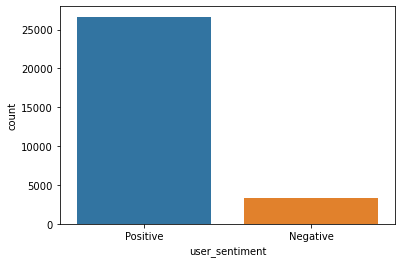

In [71]:
sns.countplot(data=classifier_df, x='user_sentiment')
plt.show()

```Highly imbalanced``` class distribution in this dataset

## Text Preprocessing

In [72]:
# spacy_sm = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

## Pre-processing
def preprocess_text(X):
    ## Set to lowercase
    X = X.str.lower()
    
    ## Remove punctuations
    X = X.str.replace(f'[{string.punctuation}]', '', regex=True)
    
    ## Remove digits or words containing digits
    X = X.str.replace('\w*\d+\w*', '', regex=True)
    
    ## Remove extra spaces within content
    X = X.str.replace('\s\s+', ' ', regex=True)
    
    return X

# def lemmatize_text(x):
#     lemma_text_list = list() 
#     tokens = spacy_sm(x)
#     for token in tokens:
#         lemma_text_list.append(token.lemma_)
#     return ' '.join(lemma_text_list)

lemmatizer = WordNetLemmatizer()

def get_wordnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ ## Adjectives
    elif tag.startswith('N'):
        return wordnet.NOUN ## Nouns
    elif tag.startswith('R'):
        return wordnet.ADV ## Adverbs
    elif tag.startswith('V'):
        return wordnet.VERB ## Verbs
    else:
        return None

## Lemmatize text
def wordnet_lemmatize_text(x):
    lemma_list = list()
    ## Get NLTK Treebank Tags
    tagged_list =  nltk.pos_tag(nltk.word_tokenize(x))
    ## Create a tuple of word and WordNet Tag
    wordnet_tagged_list = map(lambda x: (x[0], get_wordnet_tag(x[1])), tagged_list)
    for word, tag in wordnet_tagged_list:
        if tag:
            ## If tag exists then lemmatize
            lemma_list.append(lemmatizer.lemmatize(word, tag))
        else:
            lemma_list.append(word)
    return ' '.join(lemma_list)

# print(s, ' '.join(wordnet_lemmatize_text(s)), sep='\n')
classifier_df['reviews_text'] = preprocess_text(classifier_df['reviews_text'])
# classifier_df['spacy_lemma_reviews_text'] = classifier_df['reviews_text'].swifter.apply(lambda x: lemmatize_text(x))
classifier_df['lemma_reviews_text'] = classifier_df['reviews_text'].swifter.apply(lambda x: wordnet_lemmatize_text(x))

C:\Users\Noble\AppData\Local\Temp/ipykernel_34504/2504854579.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_df['reviews_text'] = preprocess_text(classifier_df['reviews_text'])


Pandas Apply:   0%|          | 0/30000 [00:00<?, ?it/s]

C:\Users\Noble\AppData\Local\Temp/ipykernel_34504/2504854579.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_df['lemma_reviews_text'] = classifier_df['reviews_text'].swifter.apply(lambda x: wordnet_lemmatize_text(x))


In [73]:
# classifier_df['spacy_lemma_reviews_text'][0]

# classifier_df['wordnet_lemma_reviews_text'][0]

classifier_df.head()

,reviews_text,user_sentiment,lemma_reviews_text
0,i love this album its very good more to the hi...,Positive,i love this album its very good more to the hi...
1,good flavor this review was collected as part ...,Positive,good flavor this review be collect as part of ...
2,good flavor,Positive,good flavor
3,i read through the reviews on here before look...,Negative,i read through the review on here before look ...
4,my husband bought this gel for us the gel caus...,Negative,my husband buy this gel for us the gel cause i...


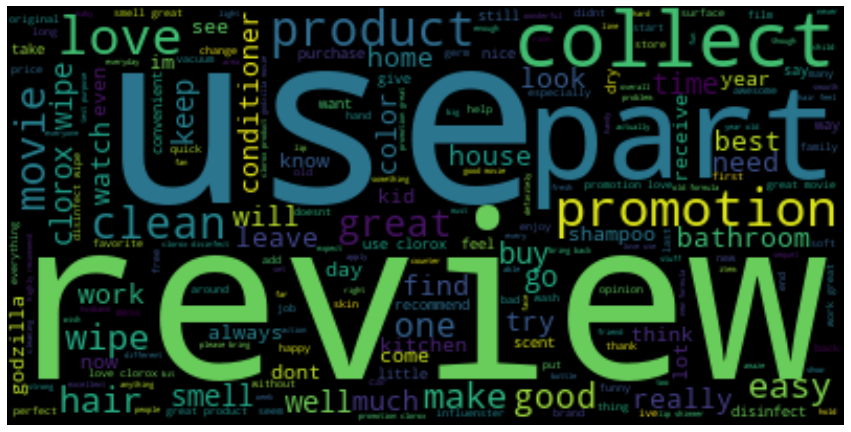

In [74]:
text = ' '.join(classifier_df['lemma_reviews_text'].tolist())
wordcloud = WordCloud().generate(text)

plt.figure(figsize=[15, 10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [75]:
classifier_df['reviews_text'][28354] ## original processed review text

'my kids absolutely loved this film so much that we watched it twice having a digital copy means that every time we get in the car we get to watch it wherever we go we even got to use our reward coupon towards the purchase of this movie so we got an additional off we got to add the points towards our next rewards coupon we love the savings we get at best buy'

In [76]:
classifier_df['lemma_reviews_text'][28354] ## lemmatized processed review text

'my kid absolutely love this film so much that we watch it twice have a digital copy mean that every time we get in the car we get to watch it wherever we go we even get to use our reward coupon towards the purchase of this movie so we get an additional off we get to add the point towards our next reward coupon we love the saving we get at best buy'

In [77]:
classifier_df.drop(columns=['reviews_text'], inplace=True)

C:\Users\Noble\anaconda3\envs\dl-nlp-env\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Feature Extraction

In [78]:
## Splitting data into train and test set
classifier_df_train, classifier_df_test = train_test_split(classifier_df, train_size=0.8, random_state=42)

In [79]:
classifier_df_train.shape, classifier_df_test.shape

((24000, 2), (6000, 2))

In [80]:
## Extracting text and target in both data set
X_train = classifier_df_train.drop(columns=['user_sentiment'])
y_train = classifier_df_train['user_sentiment']

X_test = classifier_df_test.drop(columns=['user_sentiment'])
y_test = classifier_df_test['user_sentiment']

In [81]:
X_train.head()

,lemma_reviews_text
21753,i have use this hair gel for many year and rec...
251,i love the way this awesome moisturizer immedi...
22941,i be expect something betterbetween the bug ba...
618,i slowly add product from the oil of olay rege...
17090,love this rice its a very tasty mix of several...


In [82]:
## Converting text to tfidf features
tfidf_model = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=0.005, ngram_range=(1, 3), sublinear_tf=True)
tfidf_vectors = tfidf_model.fit_transform(X_train['lemma_reviews_text'])

# print(tfidf_model.get_feature_names())
print(len(tfidf_model.get_feature_names()))

580


In [83]:
## Set train set features
X_train_tfidf = pd.DataFrame(data=tfidf_vectors.toarray(), columns=tfidf_model.get_feature_names())

## Set test set features
X_test_tfidf = pd.DataFrame(data=tfidf_model.transform(X_test['lemma_reviews_text']).toarray(), columns=tfidf_model.get_feature_names())

In [84]:
y_train.value_counts()

Positive    21284
Negative     2716
Name: user_sentiment, dtype: int64

In [85]:
## Transform tfidf features using SMOTE to address Class imbalance
smote = SMOTE()

X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

y_train_smote.value_counts()

Negative    21284
Positive    21284
Name: user_sentiment, dtype: int64

In [86]:
## Setting class labels --> Negative=0; Positive=1

y_train = np.where(y_train=='Negative',0,1)
y_train_smote = np.where(y_train_smote=='Negative',0,1)
y_test = np.where(y_test=='Negative',0,1)

## Model Building

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [88]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

In [89]:
test_metrics = pd.DataFrame(columns=['Model', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])

def set_test_metrics(model, y_true, y_pred):
    metric = list()
    metric.extend([
        model,
        roc_auc_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        accuracy_score(y_true, y_pred)
    ])
    metric = pd.Series(metric, index= test_metrics.columns)
    return metric    

### Logistic Regression

**Lets build LR model with class_weight attribute to address Class Imbalance instead of SMOTE**

In [90]:
lr_base = LogisticRegression(random_state=42, solver='saga', class_weight='balanced')

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'max_iter': [100, 200, 300],
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search_lr = GridSearchCV(
    estimator=lr_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search_lr.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


C:\Users\Noble\anaconda3\envs\dl-nlp-env\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=2)

In [91]:
cv_res_lr = pd.DataFrame(grid_search_lr.cv_results_)
cv_res_lr.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
37,15.992179,0.105523,0.013600,0.000490,1000,100,l2,"{'C': 1000, 'max_iter': 100, 'penalty': 'l2'}",0.908033,0.950299,...,0.925773,0.014002,1,0.909126,0.955982,0.939486,0.931746,0.933057,0.933879,0.015086
22,62.953401,0.262533,0.014799,0.001164,1,300,l1,"{'C': 1, 'max_iter': 300, 'penalty': 'l1'}",0.943588,0.934296,...,0.922259,0.014761,2,0.943146,0.943512,0.913149,0.919720,0.920015,0.927909,0.012829
30,25.419934,0.161559,0.015001,0.001095,100,100,l1,"{'C': 100, 'max_iter': 100, 'penalty': 'l1'}",0.906697,0.949141,...,0.920899,0.022921,3,0.907826,0.956481,0.951320,0.899336,0.926471,0.928287,0.022740
29,47.653195,0.169154,0.013801,0.000400,10,300,l2,"{'C': 10, 'max_iter': 300, 'penalty': 'l2'}",0.926714,0.914422,...,0.918316,0.004553,4,0.924261,0.927626,0.926255,0.926922,0.925603,0.926133,0.001153
27,32.457705,0.519249,0.014800,0.001599,10,200,l2,"{'C': 10, 'max_iter': 200, 'penalty': 'l2'}",0.926313,0.914536,...,0.918313,0.004449,5,0.924367,0.927273,0.926044,0.926645,0.925872,0.926040,0.000971


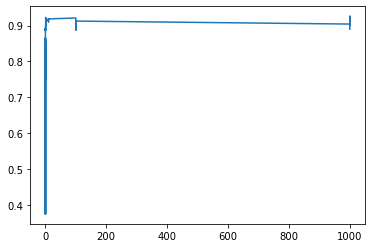

In [92]:
plt.plot(cv_res_lr['param_C'], cv_res_lr['mean_test_score'])
plt.show()

In [93]:
lr_best = grid_search_lr.best_estimator_
lr_best

LogisticRegression(C=1000, class_weight='balanced', random_state=42,
                   solver='saga')

In [94]:
## Evaluation
y_train_pred = lr_best.predict(X_train_tfidf)
y_test_pred = lr_best.predict(X_test_tfidf)

In [95]:
print('Train set \n', classification_report(y_train, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train, y_train_pred))
print('*'*100)
print('Test set \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set 
               precision    recall  f1-score   support

           0       0.49      0.88      0.63      2716
           1       0.98      0.88      0.93     21284

    accuracy                           0.88     24000
   macro avg       0.74      0.88      0.78     24000
weighted avg       0.93      0.88      0.90     24000


AUC Score 0.880009744090647
****************************************************************************************************
Test set 
               precision    recall  f1-score   support

           0       0.47      0.83      0.60       651
           1       0.98      0.89      0.93      5349

    accuracy                           0.88      6000
   macro avg       0.72      0.86      0.77      6000
weighted avg       0.92      0.88      0.89      6000


AUC Score 0.8581939171196131


In [96]:
test_metrics = test_metrics.append(set_test_metrics('Logistic Regression (Class Weight)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667


**Lets try rebuilding LR model using SMOTE technique**

In [97]:
lr_base = LogisticRegression(random_state=42, solver='saga')

folds = KFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'max_iter': [100, 200, 300],
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search_lr_smote = GridSearchCV(
    estimator=lr_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    n_jobs=-1,
    verbose=3,
    return_train_score=True
)

grid_search_lr_smote.fit(X_train_tfidf_smote, y_train_smote)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=3)

In [98]:
cv_res_lr_smote = pd.DataFrame(grid_search_lr_smote.cv_results_)
cv_res_lr_smote.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
25,14.530878,0.700290,0.020000,0.000633,10,100,l2,"{'C': 10, 'max_iter': 100, 'penalty': 'l2'}",0.917510,0.917881,...,0.918671,0.002037,1,0.924947,0.925803,0.925292,0.926587,0.924494,0.925425,0.000722
27,13.793685,0.446587,0.025600,0.003200,10,200,l2,"{'C': 10, 'max_iter': 200, 'penalty': 'l2'}",0.917510,0.917881,...,0.918671,0.002037,1,0.924947,0.925803,0.925292,0.926587,0.924494,0.925425,0.000722
29,13.704885,0.564719,0.021000,0.000895,10,300,l2,"{'C': 10, 'max_iter': 300, 'penalty': 'l2'}",0.917510,0.917881,...,0.918671,0.002037,1,0.924947,0.925803,0.925292,0.926587,0.924494,0.925425,0.000722
40,96.902032,0.929922,0.013998,0.002100,1000,300,l1,"{'C': 1000, 'max_iter': 300, 'penalty': 'l1'}",0.918232,0.916606,...,0.918578,0.002563,4,0.925319,0.925903,0.926204,0.926805,0.925417,0.925929,0.000544
37,29.508339,0.457216,0.032600,0.011534,1000,100,l2,"{'C': 1000, 'max_iter': 100, 'penalty': 'l2'}",0.918212,0.916384,...,0.918557,0.002566,5,0.925327,0.925971,0.926260,0.926896,0.925380,0.925967,0.000583


In [99]:
lr_smote_best = grid_search_lr_smote.best_estimator_
lr_smote_best

LogisticRegression(C=10, random_state=42, solver='saga')

In [100]:
## Evaluation
y_train_pred = lr_smote_best.predict(X_train_tfidf_smote)
y_test_pred = lr_smote_best.predict(X_test_tfidf)

In [101]:
print('Train set: \n', classification_report(y_train_smote, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train_smote, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     21284
           1       0.94      0.91      0.93     21284

    accuracy                           0.93     42568
   macro avg       0.93      0.93      0.93     42568
weighted avg       0.93      0.93      0.93     42568


AUC Score 0.926517571884984
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.52      0.83      0.64       651
           1       0.98      0.91      0.94      5349

    accuracy                           0.90      6000
   macro avg       0.75      0.87      0.79      6000
weighted avg       0.93      0.90      0.91      6000


AUC Score 0.8681023112119669


In [102]:
test_metrics = test_metrics.append(set_test_metrics('Logistic Regression (SMOTE)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.868102,0.977625,0.906712,0.940834,0.898333


### Random Forest

**Lets build Random Forest ensemble with class_weight attribute to address Class Imbalance instead of SMOTE**

In [103]:
## Set estimator
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

## folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## hyper-parameters
params = {
    'max_depth': [3,5,10,15,20],
    'n_estimators': [50,100,150,200],
    'min_samples_split': [200, 250, 300],
    'min_samples_leaf': [100, 150, 200]
}

## Instantiate GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

## Fit model
grid_search_rf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20],
                         'min_samples_leaf': [100, 150, 200],
                         'min_samples_split': [200, 250, 300],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='f1', verbose=2)

In [104]:
cv_res_rf = pd.DataFrame(grid_search_rf.cv_results_)
cv_res_rf.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
147,46.126484,0.202549,0.677797,0.016916,20,100,200,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.892484,...,0.889352,0.004832,1,0.893319,0.890933,0.891530,0.889473,0.892560,0.891563,0.001330
151,45.938059,0.340287,0.666724,0.024625,20,100,250,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.892088,...,0.889280,0.004655,2,0.893179,0.890940,0.891941,0.889038,0.892340,0.891488,0.001421
155,46.090594,0.654316,0.750123,0.060377,20,100,300,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.891496,...,0.889268,0.004733,3,0.892665,0.890954,0.891940,0.889906,0.892418,0.891577,0.001020
146,34.289789,0.713147,0.536998,0.032255,20,100,200,150,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.891637,...,0.888669,0.004701,4,0.891116,0.891295,0.889778,0.888932,0.890523,0.890329,0.000877
154,34.091997,0.608110,0.535808,0.026400,20,100,300,150,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.889457,...,0.888109,0.004555,5,0.889521,0.891111,0.890027,0.888540,0.890061,0.889852,0.000835


In [105]:
rf_best = grid_search_rf.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=100, min_samples_split=200,
                       n_estimators=200, random_state=42)

In [106]:
## Evaluation
y_train_pred = rf_best.predict(X_train_tfidf)
y_test_pred = rf_best.predict(X_test_tfidf)

In [107]:
print('Train set: \n', classification_report(y_train, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.38      0.86      0.52      2716
           1       0.98      0.82      0.89     21284

    accuracy                           0.82     24000
   macro avg       0.68      0.84      0.71     24000
weighted avg       0.91      0.82      0.85     24000


AUC Score 0.8380924402961673
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.37      0.83      0.51       651
           1       0.98      0.83      0.89      5349

    accuracy                           0.83      6000
   macro avg       0.67      0.83      0.70      6000
weighted avg       0.91      0.83      0.85      6000


AUC Score 0.8280216035901452


In [108]:
test_metrics = test_metrics.append(set_test_metrics('Random Forest (Class Weight)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.868102,0.977625,0.906712,0.940834,0.898333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667


**Lets build Random Forest ensemble using SMOTE**

In [109]:
## Set estimator
rf_base = RandomForestClassifier(random_state=42)

## folds
folds = KFold(n_splits=5, shuffle=True, random_state=42)

## hyper-parameters
params = {
    'max_depth': [3,5,10,15,20],
    'n_estimators': [50,100,150,200],
    'min_samples_split': [200, 250, 300],
    'min_samples_leaf': [100, 150, 200]
}

## Instantiate GridSearchCV
grid_search_rf_smote = GridSearchCV(
    estimator=rf_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

## Fit model
grid_search_rf_smote.fit(X_train_tfidf_smote, y_train_smote)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20],
                         'min_samples_leaf': [100, 150, 200],
                         'min_samples_split': [200, 250, 300],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='f1', verbose=2)

In [110]:
cv_res_rf_smote = pd.DataFrame(grid_search_rf_smote.cv_results_)
cv_res_rf_smote.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
147,21.619050,0.185158,0.240600,0.001743,20,100,200,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.858367,...,0.859849,0.002815,1,0.860911,0.864543,0.862776,0.863434,0.863276,0.862988,0.001188
151,21.849707,0.198580,0.238509,0.005314,20,100,250,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.857892,...,0.859552,0.002438,2,0.860695,0.863479,0.863136,0.863777,0.863034,0.862824,0.001096
155,21.586652,0.198255,0.239801,0.004309,20,100,300,200,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.857925,...,0.859463,0.002581,3,0.860960,0.863103,0.862096,0.862881,0.863183,0.862444,0.000836
145,10.909831,0.085578,0.147600,0.009133,20,100,200,100,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.857449,...,0.858646,0.001891,4,0.860235,0.863684,0.862683,0.861539,0.861891,0.862006,0.001152
153,11.030920,0.043722,0.157400,0.014732,20,100,300,100,"{'max_depth': 20, 'min_samples_leaf': 100, 'mi...",0.857619,...,0.858419,0.002125,5,0.859339,0.863262,0.861922,0.860907,0.861435,0.861373,0.001283


In [111]:
rf_smote_best = grid_search_rf_smote.best_estimator_
rf_smote_best

RandomForestClassifier(max_depth=20, min_samples_leaf=100,
                       min_samples_split=200, n_estimators=200,
                       random_state=42)

In [112]:
## Evaluation
y_train_pred = rf_smote_best.predict(X_train_tfidf_smote)
y_test_pred = rf_smote_best.predict(X_test_tfidf)

In [113]:
print('Train set: \n', classification_report(y_train_smote, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train_smote, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87     21284
           1       0.89      0.85      0.87     21284

    accuracy                           0.87     42568
   macro avg       0.87      0.87      0.87     42568
weighted avg       0.87      0.87      0.87     42568


AUC Score 0.8687511745912422
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.40      0.82      0.54       651
           1       0.97      0.85      0.91      5349

    accuracy                           0.85      6000
   macro avg       0.69      0.83      0.72      6000
weighted avg       0.91      0.85      0.87      6000


AUC Score 0.8345696210928784


In [114]:
test_metrics = test_metrics.append(set_test_metrics('Random Forest (SMOTE)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.868102,0.977625,0.906712,0.940834,0.898333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.834570,0.974551,0.851935,0.909127,0.848167


## Multinominal Naive Bayes

In [115]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [116]:
## Evaluation
y_train_pred = mnb.predict(X_train_tfidf)
y_test_pred = mnb.predict(X_test_tfidf)

In [117]:
print('Train set: \n', classification_report(y_train, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.55      0.11      0.19      2716
           1       0.90      0.99      0.94     21284

    accuracy                           0.89     24000
   macro avg       0.72      0.55      0.56     24000
weighted avg       0.86      0.89      0.86     24000


AUC Score 0.5505500131609575
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.52      0.10      0.17       651
           1       0.90      0.99      0.94      5349

    accuracy                           0.89      6000
   macro avg       0.71      0.55      0.56      6000
weighted avg       0.86      0.89      0.86      6000


AUC Score 0.5455703421889444


In [118]:
test_metrics = test_metrics.append(set_test_metrics('Multi Naive Bayes', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.868102,0.977625,0.906712,0.940834,0.898333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.834570,0.974551,0.851935,0.909127,0.848167
4,Multi Naive Bayes,0.545570,0.900511,0.988222,0.942330,0.892167


In [119]:
mnb_smote = MultinomialNB()
mnb_smote.fit(X_train_tfidf_smote, y_train_smote)

MultinomialNB()

In [120]:
## Evaluation
y_train_pred = mnb_smote.predict(X_train_tfidf_smote)
y_test_pred = mnb_smote.predict(X_test_tfidf)

In [121]:
print('Train set: \n', classification_report(y_train_smote, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train_smote, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.83     21284
           1       0.83      0.84      0.84     21284

    accuracy                           0.83     42568
   macro avg       0.83      0.83      0.83     42568
weighted avg       0.83      0.83      0.83     42568


AUC Score 0.8349934222890434
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.37      0.81      0.51       651
           1       0.97      0.83      0.90      5349

    accuracy                           0.83      6000
   macro avg       0.67      0.82      0.70      6000
weighted avg       0.91      0.83      0.86      6000


AUC Score 0.8214753091365542


In [122]:
test_metrics = test_metrics.append(set_test_metrics('Multi Naive Bayes (SMOTE)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.868102,0.977625,0.906712,0.940834,0.898333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.834570,0.974551,0.851935,0.909127,0.848167
4,Multi Naive Bayes,0.545570,0.900511,0.988222,0.942330,0.892167
5,Multi Naive Bayes (SMOTE),0.821475,0.972938,0.833427,0.897795,0.830833


## XGBoost

In [123]:
from xgboost import XGBClassifier

In [124]:
## For setting scale_pos_weight for unbalanced dataset
cls_count = np.bincount(y_train)
cls_weight = cls_count[0]/cls_count[1]

## Set estimator
xgb_base = XGBClassifier(objective='binary:logistic', scale_pos_weight=cls_weight, n_jobs=-1)

## CV folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params= {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.25],
    'min_child_weight': [100,250,500],
    'gamma': [0.1, 0.2, 0.5, 1, 1.5],
#     'subsample': [0.6, 0.8, 1],
#     'colsample_bytree': [0.6, 0.8, 1],
    'max_depth': [3,5,7,8]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\Noble\anaconda3\envs\dl-nlp-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_c...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_weight=0.1276075925577899,
                                     subsample=None, tree_method=None,
                                     validate_para

In [125]:
cv_res_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
cv_res_xgb.nlargest(5, 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
51,45.246009,0.224538,0.083799,0.006586,0.1,0.25,5,100,"{'gamma': 0.1, 'learning_rate': 0.25, 'max_dep...",0.813130,...,0.806862,0.009891,1,0.808843,0.814239,0.815434,0.812285,0.789918,0.808144,0.009382
114,46.747031,0.569178,0.088800,0.008447,0.2,0.25,7,100,"{'gamma': 0.2, 'learning_rate': 0.25, 'max_dep...",0.812491,...,0.806102,0.009263,2,0.808572,0.811651,0.815651,0.810798,0.790238,0.807382,0.008872
117,46.021447,0.417896,0.081200,0.017882,0.2,0.25,8,100,"{'gamma': 0.2, 'learning_rate': 0.25, 'max_dep...",0.812491,...,0.806102,0.009263,2,0.808572,0.811651,0.815651,0.810798,0.790238,0.807382,0.008872
102,46.737662,0.283675,0.088201,0.012480,0.2,0.2,7,100,"{'gamma': 0.2, 'learning_rate': 0.2, 'max_dept...",0.815872,...,0.805738,0.014445,4,0.813047,0.812922,0.787902,0.807198,0.812161,0.806646,0.009617
105,45.898698,0.345182,0.082601,0.015630,0.2,0.2,8,100,"{'gamma': 0.2, 'learning_rate': 0.2, 'max_dept...",0.815872,...,0.805738,0.014445,4,0.813047,0.812922,0.787902,0.807198,0.812161,0.806646,0.009617


In [126]:
xgb_best = grid_search_xgb.best_estimator_
xgb_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=5, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1276075925577899,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [127]:
## Evaluation
y_train_pred = xgb_best.predict(X_train_tfidf)
y_test_pred = xgb_best.predict(X_test_tfidf)

In [128]:
print('Train set: \n', classification_report(y_train, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.27      0.82      0.40      2716
           1       0.97      0.71      0.82     21284

    accuracy                           0.73     24000
   macro avg       0.62      0.77      0.61     24000
weighted avg       0.89      0.73      0.78     24000


AUC Score 0.7670809784998943
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.25      0.77      0.38       651
           1       0.96      0.72      0.82      5349

    accuracy                           0.72      6000
   macro avg       0.61      0.75      0.60      6000
weighted avg       0.89      0.72      0.78      6000


AUC Score 0.7465097485812844


In [129]:
test_metrics = test_metrics.append(set_test_metrics('XGB', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.868102,0.977625,0.906712,0.940834,0.898333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.834570,0.974551,0.851935,0.909127,0.848167
4,Multi Naive Bayes,0.545570,0.900511,0.988222,0.942330,0.892167
5,Multi Naive Bayes (SMOTE),0.821475,0.972938,0.833427,0.897795,0.830833
6,XGB,0.746510,0.963176,0.718826,0.823252,0.724833


**Lets build XGBoost model using SMOTE**

In [130]:
## Set estimator
xgb_base = XGBClassifier(objective='binary:logistic', n_jobs=-1)

## CV folds
folds = KFold(n_splits=5, shuffle=True, random_state=42)

params= {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.25],
    'min_child_weight': [100,250,500],
    'gamma': [0.1, 0.2, 0.5, 1, 1.5],
#     'subsample': [0.6, 0.8, 1],
#     'colsample_bytree': [0.6, 0.8, 1],
    'max_depth': [3,5,7,8]
}

grid_search_xgb_smote = GridSearchCV(
    estimator=xgb_base,
    param_grid=params,
    cv=folds,
    scoring='f1',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb_smote.fit(X_train_tfidf_smote, y_train_smote)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\Noble\anaconda3\envs\dl-nlp-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weigh...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                        

In [131]:
cv_res_xgb_smote = pd.DataFrame(grid_search_xgb_smote.cv_results_)
cv_res_xgb_smote.nlargest(5, 'mean_test_score') 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
177,135.230492,1.066638,0.114798,0.023446,0.5,0.25,8,100,"{'gamma': 0.5, 'learning_rate': 0.25, 'max_dep...",0.863264,...,0.862190,0.002439,1,0.873678,0.870775,0.871048,0.872713,0.872843,0.872211,0.001115
117,133.697483,1.256149,0.126000,0.027174,0.2,0.25,8,100,"{'gamma': 0.2, 'learning_rate': 0.25, 'max_dep...",0.861516,...,0.862087,0.001865,2,0.871451,0.871624,0.870953,0.872254,0.873478,0.871952,0.000869
57,133.506014,0.742316,0.115601,0.014650,0.1,0.25,8,100,"{'gamma': 0.1, 'learning_rate': 0.25, 'max_dep...",0.861516,...,0.862041,0.003204,3,0.871618,0.871635,0.870513,0.872158,0.872371,0.871659,0.000644
237,133.682229,0.912110,0.103399,0.018030,1,0.25,8,100,"{'gamma': 1, 'learning_rate': 0.25, 'max_depth...",0.862239,...,0.861866,0.002743,4,0.872454,0.871477,0.870823,0.871919,0.871568,0.871648,0.000537
297,121.655027,7.050408,0.074001,0.011366,1.5,0.25,8,100,"{'gamma': 1.5, 'learning_rate': 0.25, 'max_dep...",0.861298,...,0.861706,0.002941,5,0.869928,0.871868,0.871473,0.872201,0.872738,0.871642,0.000952


In [132]:
xgb_smote_best = grid_search_xgb_smote.best_estimator_
xgb_smote_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=8, min_child_weight=100, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [133]:
## Evaluation
y_train_pred = xgb_smote_best.predict(X_train_tfidf_smote)
y_test_pred = xgb_smote_best.predict(X_test_tfidf)

In [134]:
print('Train set: \n', classification_report(y_train_smote, y_train_pred))
# pd.Series(y_train).map({'Negative':0, 'Positive':1})
print('\nAUC Score', roc_auc_score(y_train_smote, y_train_pred))
print('*'*100)
print('Test set: \n', classification_report(y_test, y_test_pred))
print('\nAUC Score', roc_auc_score(y_test, y_test_pred))

Train set: 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     21284
           1       0.92      0.86      0.88     21284

    accuracy                           0.89     42568
   macro avg       0.89      0.89      0.89     42568
weighted avg       0.89      0.89      0.89     42568


AUC Score 0.8886722420597633
****************************************************************************************************
Test set: 
               precision    recall  f1-score   support

           0       0.38      0.77      0.51       651
           1       0.97      0.85      0.90      5349

    accuracy                           0.84      6000
   macro avg       0.67      0.81      0.71      6000
weighted avg       0.90      0.84      0.86      6000


AUC Score 0.8094716872872573


In [135]:
test_metrics = test_metrics.append(set_test_metrics('XGB (SMOTE)', y_test, y_test_pred), ignore_index=True)

test_metrics

,Model,AUC,Precision,Recall,F1,Accuracy
0,Logistic Regression (Class Weight),0.858194,0.977137,0.886895,0.929831,0.880667
1,Logistic Regression (SMOTE),0.868102,0.977625,0.906712,0.940834,0.898333
2,Random Forest (Class Weight),0.828022,0.975680,0.825014,0.894044,0.825667
3,Random Forest (SMOTE),0.834570,0.974551,0.851935,0.909127,0.848167
4,Multi Naive Bayes,0.545570,0.900511,0.988222,0.942330,0.892167
5,Multi Naive Bayes (SMOTE),0.821475,0.972938,0.833427,0.897795,0.830833
6,XGB,0.746510,0.963176,0.718826,0.823252,0.724833
7,XGB (SMOTE),0.809472,0.968190,0.847822,0.904017,0.839500


In [138]:
import pickle
import os

In [140]:
if not os.path.exists('./models'):
    os.makedirs('./models')

In [142]:
with open('./models/model.pkl', 'wb') as f:
    pickle.dump(lr_smote_best, f)

with open('./models/tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf_model, f)

with open('./models/user_recommendations.pkl', 'wb') as f:
    pickle.dump(user_final_ratings, f)

In [144]:
with open('./models/tfidf.pkl', 'rb') as f:
    tf_idf = pickle.load(f)
    
len(tf_idf.get_feature_names())

580

In [145]:
with open('./models/user_recommendations.pkl', 'rb') as f:
    rec = pickle.load(f)
    
len(rec.index)

19431

In [146]:
len(rec.columns)

260